In [1]:
import os
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition

/Users/sameer-macair/PycharmProjects/agentic_rag/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [17]:
# Load environment variables from .env file located at a specific path
load_dotenv(dotenv_path='../.env')

def _set_env():
    print("LANGCHAIN_ENDPOINT:", os.environ["LANGCHAIN_ENDPOINT"])

_set_env()

LANGCHAIN_ENDPOINT: https://api.smith.langchain.com


In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

# Create a graph with the State type
graph_builder = StateGraph(State)

In [12]:
tool = TavilySearchResults(max_results=2)
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'}]

In [5]:
llm = ChatOpenAI(model= 'gpt-4o-mini', temperature=0.0)
llm_with_tools = llm.bind_tools(tools)

In [6]:
def chatbot_llm_openai(state: State):
    # Use the LLM to generate a response based on the current conversation history.
    response = llm.invoke(state['messages'])

    return {"messages": [response]}

graph_builder.add_node("chatbot_llm_openai_node", chatbot_llm_openai)

In [7]:
# For this basic chatbot, the 'chatbot' node is both the entry and finish point
graph_builder.add_edge(START, "chatbot_llm_openai_node")
graph_builder.add_edge("chatbot_llm_openai_node", END)

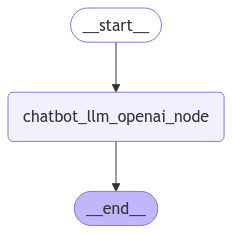

In [8]:
graph_builder.compile()

In [ ]:
#Below, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. 
# It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot_llm_openai_node", tools_condition)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot_llm_openai_node")
graph_builder.set_entry_point("chatbot_llm_openai_node")


Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `tools` already present.

In [14]:
graph = graph_builder.compile()

In [15]:
# ... (Previous code to define State, graph_builder, nodes, and edges)

from langgraph.checkpoint.memory import MemorySaver

# Create a MemorySaver object to act as the checkpointer
memory = MemorySaver()

# Compile the graph, passing in the 'memory' object as the checkpointer
graph = graph_builder.compile(checkpointer=memory)

# ... (Rest of the code to run the chatbot)
